# <a id='toc1_'></a>[Data generation: Solar Power](#toc0_)

This notebook describes the generation of solarpower data, involving `CDS` data and the `Feedinlib`.

This notebook builds on top of the notebook presented in [this repository](https://github.com/PeijieZ/WindpowerlibTurbine-model).

Note that `pvlib` is fixed at `0.8.1`, due to a bug in `0.10.3` (more information [here](https://stackoverflow.com/questions/77108007/attributeerror-pvsystem-object-has-no-attribute-racking-model))

**Table of contents**<a id='toc0_'></a>    
- [Data generation: Solar Power](#toc1_)    
    - [CDS](#toc1_1_1_)    
    - [Feedinlib](#toc1_1_2_)    
  - [Download solar data](#toc1_2_)    
  - [Convert raw data to radiation data](#toc1_3_)    
  - [Generate Solar power data](#toc1_4_)    
  - [Scale data](#toc1_5_)    
  - [Extrapolate data](#toc1_6_)    
  - [Export data](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[CDS](#toc0_)
This tool derives solarpower-data from actual weather data from the [Climate Data Store](https://cds.climate.copernicus.eu) provided by [Copernicus](https://copernicus.eu).

To download data from the CDS, one must 
1. [register](https://cds.climate.copernicus.eu/user/register) and create an account, and
2. [install the API](https://cds.climate.copernicus.eu/api-how-to).

### <a id='toc1_1_2_'></a>[Feedinlib](#toc0_)
Processing of the CDS data is done using [feedinlib](https://github.com/oemof/feedinlib).
To be able to process CDS's ED5-format data, an unreleased version of the software must be installed.

The command for this is as follows: `$> pip install https://github.com/oemof/feedinlib/archive/master.zip`

In [1]:
from feedinlib import era5

## <a id='toc1_2_'></a>[Download solar data](#toc0_)
The first step is to download solar data for a particular time and place.
Copernicus provides data for locations within the EU.

In [2]:
import pandas as pd

In [3]:
# Location: European Parliament in Brussels, Belgium
longitude, latitude = 4.375, 50.839

# Time span
start_date, end_date = '2020-07-01', '2020-07-31'

# Solar data requested for download
variable = "pvlib"

In [4]:
def request_CDS_data(target_file: str) -> None:
    """
    Request CDS data.
    :param target_file: file to store data in.
    """
    era5.get_era5_data_from_datespan_and_position(
        variable=variable,
        start_date=start_date,
        end_date=end_date,
        latitude=latitude,
        longitude=longitude,
        target_file=target_file
    )

# Request data
target_file = 'src/ERA5_pv_data_july_2020.nc'

# Uncomment the below line if you do wish to request the data (again). Note that this is an expensive API request
# request_CDS_data(target_file)

## <a id='toc1_3_'></a>[Convert raw data to radiation data](#toc0_)

In [5]:
# Load weather data from target_file.
import xarray as xr
raw_data = xr.open_dataset(target_file, chunks=None)

# show the raw data
raw_data

<xarray.Dataset> Size: 21kB
Dimensions:    (longitude: 1, latitude: 1, time: 744)
Coordinates:
  * longitude  (longitude) float32 4B 4.5
  * latitude   (latitude) float32 4B 50.75
  * time       (time) datetime64[ns] 6kB 2020-07-01 ... 2020-07-31T23:00:00
Data variables:
    fdir       (time, latitude, longitude) float32 3kB ...
    ssrd       (time, latitude, longitude) float32 3kB ...
    t2m        (time, latitude, longitude) float32 3kB ...
    u10        (time, latitude, longitude) float32 3kB ...
    v10        (time, latitude, longitude) float32 3kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-27 22:45:08 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
# Convert to solarpower data
data = era5.format_pvlib(raw_data)

# Drop location information from index
new_idx = data.index.droplevel(['longitude', 'latitude'])
data = data.set_index(new_idx)

data

,wind_speed,temp_air,ghi,dhi
time,,,,
2020-06-30 23:30:00+00:00,4.647963,18.220306,-0.000035,-0.000035
2020-07-01 00:30:00+00:00,4.783858,17.888763,-0.000035,-0.000035
2020-07-01 01:30:00+00:00,4.742291,17.456787,-0.000035,-0.000035
2020-07-01 02:30:00+00:00,4.561267,17.333466,-0.000035,-0.000035
2020-07-01 03:30:00+00:00,4.505437,17.345551,0.534757,0.511944
...,...,...,...,...
2020-07-31 18:30:00+00:00,2.386088,29.413696,60.135902,36.773159
2020-07-31 19:30:00+00:00,2.538475,27.346863,3.222014,3.005278
2020-07-31 20:30:00+00:00,2.628344,26.686829,-0.000035,-0.000035


Text(0, 0.5, 'Solar power (ghi)')

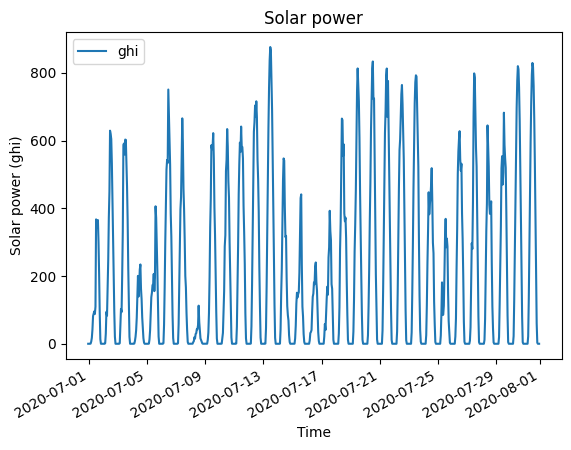

In [7]:
# Plot ghi
import matplotlib.pyplot as plt

# Generate plot
data.loc[:, ['ghi']].plot(title='Solar power')
plt.xlabel('Time')
plt.ylabel('Solar power (ghi)')

## <a id='toc1_4_'></a>[Generate Solar power data](#toc0_)

You can use the Photovoltaic plant from the database, or create your own plant for modeling.

In [8]:
from feedinlib import Photovoltaic
from feedinlib import get_power_plant_data

In [9]:
# Solar panel models
modules_df = get_power_plant_data("SandiaMod")
modules_df
pv_model = modules_df.columns[-5]

# Inverter models
inverters_df = get_power_plant_data("cecinverter")
inverter_model = inverters_df.columns[-1]

inverters_df

,ABB__MICRO_0_25_I_OUTD_US_208__208V_,ABB__MICRO_0_25_I_OUTD_US_240__240V_,ABB__MICRO_0_3_I_OUTD_US_208__208V_,ABB__MICRO_0_3_I_OUTD_US_240__240V_,ABB__MICRO_0_3HV_I_OUTD_US_208__208V_,ABB__MICRO_0_3HV_I_OUTD_US_240__240V_,ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_,ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_,ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_,ABB__PVI_3_0_OUTD_S_US__208V_,...,Zigor__Sunzet_3_TL_US__240V_,i_Energy__GT260__240V_,iPower__SHO_1_1__120V_,iPower__SHO_2_0__240V_,iPower__SHO_2_5__240V_,iPower__SHO_3_0__240V_,iPower__SHO_3_5__240V_,iPower__SHO_4_6__208V_,iPower__SHO_4_8__240V_,iPower__SHO_5_2__240V_
Vac,208,240,208,240,208,240,208,480,480,208,...,240,240,120,240,240,240,240,208,240,240
Pso,2.089607,2.240412,1.846506,1.950539,1.769444,1.843781,46.863808,67.790878,62.554672,18.166279,...,36.033405,2.530101,22.09536,24.465775,42.776474,31.682003,64.774162,54.570091,85.145699,62.486748
Paco,250.0,250.0,300.0,300.0,300.0,300.0,10000.0,10000.0,12000.0,3000.0,...,3180.0,230.0,1100.0,2000.0,2500.0,3000.0,3500.0,4600.0,4800.0,5200.0
Pdco,259.588593,259.492065,311.66925,311.580872,312.421082,312.004578,10488.306641,10295.979492,12358.804688,3142.30127,...,3315.654297,245.630447,1194.094849,2161.879639,2632.835693,3205.932617,3641.840332,4797.806641,4968.027832,5382.856934
Vdco,40.0,40.0,40.0,40.0,45.0,45.0,320.0,362.0,370.0,310.0,...,375.0,40.0,182.0,199.0,218.0,222.5,263.0,254.0,263.0,280.0
C0,-0.000041,-0.000039,-0.000033,-0.000034,-0.000045,-0.000035,-0.000003,-0.000001,-0.000001,-0.000008,...,-0.000008,0.000062,-0.000021,-0.000013,-0.000014,-0.000008,-0.000009,-0.000006,-0.000006,-0.000005
C1,-0.000091,-0.000132,-0.000192,-0.000256,-0.000196,-0.000227,-0.000036,-0.000049,-0.000056,-0.000011,...,-0.000075,-0.000098,0.000057,0.000055,0.000061,0.000036,0.000035,0.000028,0.000034,0.000044
C2,0.000494,0.002418,0.000907,0.002453,0.001959,-0.000526,0.000305,-0.00052,-0.001437,0.000999,...,0.000544,0.000231,0.002001,0.001703,0.002053,0.001708,0.001417,0.001381,0.000586,0.00126
C3,-0.013171,-0.014926,-0.031742,-0.028223,-0.023725,-0.041214,-0.002351,-0.003855,-0.007112,-0.000287,...,-0.000338,0.121032,0.000623,0.000315,0.00153,0.00086,0.001218,0.000889,0.000195,0.000367
Pnt,0.075,0.075,0.09,0.09,0.09,0.09,0.1,0.4,0.4,0.1,...,0.954,0.069,0.33,0.6,0.75,0.9,1.05,1.38,1.44,1.56


In [10]:
panel_properties = {
    'azimuth': 180,
    'tilt': 30,
    'module_name': pv_model,
    'surface_type': 'urban',
    'inverter_name': inverter_model,
}

my_panel = Photovoltaic(**panel_properties)

In [11]:
# Generate data
performance = my_panel.feedin(weather=data, location=[latitude, longitude])

# Correct for NaN
performance = performance.fillna(0)

performance

/home/erik/Documents/billing/.venv/lib/python3.10/site-packages/pvlib/pvsystem.py:478: pvlibDeprecationWarning: temperature_model_parameters, racking_model, and module_type are not specified. Reverting to deprecated default: SAPM cell temperature model parameters for a glass/glass module in open racking. In v0.9, temperature_model_parameters or a valid combination of racking_model and module_type will be required.
  warnings.warn(


time
2020-06-30 23:30:00+00:00    0.00
2020-07-01 00:30:00+00:00    0.00
2020-07-01 01:30:00+00:00    0.00
2020-07-01 02:30:00+00:00    0.00
2020-07-01 03:30:00+00:00    0.00
                             ... 
2020-07-31 18:30:00+00:00   -1.56
2020-07-31 19:30:00+00:00    0.00
2020-07-31 20:30:00+00:00    0.00
2020-07-31 21:30:00+00:00    0.00
2020-07-31 22:30:00+00:00    0.00
Length: 744, dtype: float64

Text(0, 0.5, 'Power (W)')

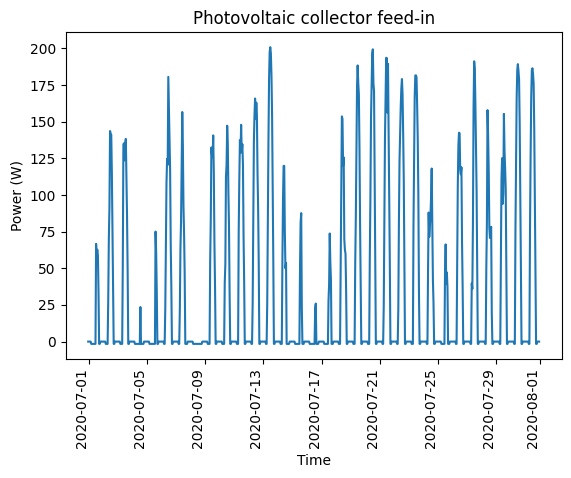

In [12]:
# plot calculated feed-in
import matplotlib.pyplot as plt

# Generate plot
performance.plot(title='Photovoltaic collector feed-in')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Power (W)')

In [13]:
# Convert to pandas dataframe
df = pd.DataFrame(performance)

df

,0
time,
2020-06-30 23:30:00+00:00,0.00
2020-07-01 00:30:00+00:00,0.00
2020-07-01 01:30:00+00:00,0.00
2020-07-01 02:30:00+00:00,0.00
2020-07-01 03:30:00+00:00,0.00
...,...
2020-07-31 18:30:00+00:00,-1.56
2020-07-31 19:30:00+00:00,0.00
2020-07-31 20:30:00+00:00,0.00


## <a id='toc1_5_'></a>[Scale data](#toc0_)
Next, we scale the data to PV panels with 2.3kW, 3.6kW and 4.7kW capacity.

In [14]:
# Settings
MAX_CAPACITIES = [4.7, 3.6, 2.3] # kW
DECIMAL_PRECISION = 4

In [15]:
# Get max output value
max_output = df.T.iloc[0].max()

# Clean capacities: remove negative numbers
capacities = df.T.iloc[0].values
capacities = [
    max(0, v)
    for v in capacities
]

# Scale values
scaled_capacities = []
for capacity in MAX_CAPACITIES:
    scale = capacity / max_output

    scaled_capacity = [
        round(scale * c, DECIMAL_PRECISION)
        for c in capacities
    ]
    scaled_capacities.append(scaled_capacity)

    df.insert(1, f"{capacity}W", scaled_capacity)

# Drop original values
df = df.T.iloc[-3:].T

## <a id='toc1_6_'></a>[Extrapolate data](#toc0_)

Next, we generate pv data for multiple pv panels by means of randomized sampling from the existing dataset.

In [16]:
# Generation settings
NR_PV_PANELS = 25
PV_EFFICIENCY_BOUNDS = 0.9, 1.1

In [17]:
from typing import List, Callable
import random

Vector = List[float]

def generate_vector(
        input_vectors: List[Vector], 
        randomizer: Callable[[float], float]
    ) -> Vector:
    """
    Generate random vector, using uniform sampling.
    :param input_data: set of vectors to sample from
    :param randomizer: callback used to compute a new value.
    :returns: uniformly random sampled vector
    """
    # 1. Select random existing data vector
    base_vector = random.choice(input_vectors)

    # 2. Generate random vector using uniformly random sampling
    new_vec = []
    for val in base_vector:
        new_val = randomizer(val)
        rounded_new_val = round(new_val, DECIMAL_PRECISION)
        new_vec.append(rounded_new_val)
    
    return new_vec

In [18]:
def randomizer(val: float) -> float:
    return (val * random.uniform(*PV_EFFICIENCY_BOUNDS))

nr_new_capacities = NR_PV_PANELS - len(scaled_capacities)
for idx in range(nr_new_capacities):
    # Generate new performance
    new_capacity = generate_vector(scaled_capacities, randomizer)

    # Add new performance to dataframe
    perf_series = pd.Series(new_capacity, index=df.index)
    df.insert(3, idx, perf_series)

Text(0, 0.5, 'Power (kW)')

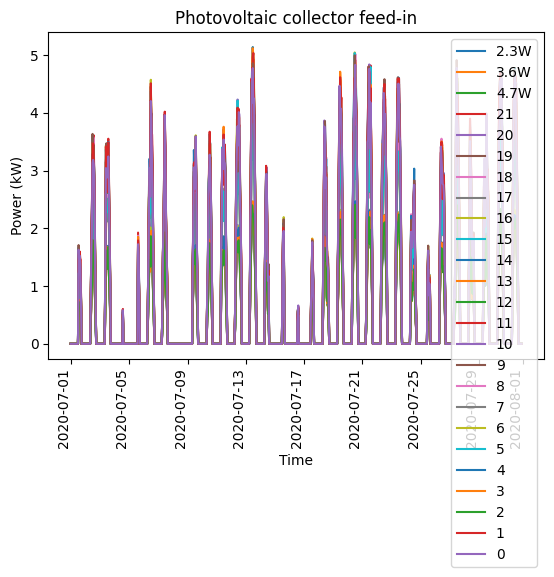

In [19]:
import matplotlib.pyplot as plt

# Generate plot
df.plot(title='Photovoltaic collector feed-in')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Power (kW)')

## <a id='toc1_7_'></a>[Export data](#toc0_)

In [22]:
def export_data(nr_days: int):
    samples = nr_days * 24
    selection = df.iloc[:samples]
    selection.to_json(f'out/solarpower_{nr_days}_days.json', indent=4)

export_data(31)